# Test Sampling Without Replacement

Do the algorithms work? Are they non-biased? and how fast are they?

Algorithms:
  * Reservoir algorithm R
  * Reservoir algorithm L
  * Fisher Yates
  * Hidden shuffle 
     


In [1]:
import gfort2py as gf
import os
import numpy as np
import matplotlib.pyplot as plt


def plot_frequency(m_samples, n_range, occurrences):
    # Uniform probability of getting each value
    uniform_p = m_samples / n_range
    normalize =  1. / (n_repeat * uniform_p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_range + 1), occurrences[1:] * normalize)
    plt.xlabel('Value')
    plt.ylabel('Normalised Frequency of Selection')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_range + 1), (occurrences[1:] * normalize) - 1)
    plt.xlabel('Value')
    plt.axhline(y=0.0, color='r', linestyle='--', label=f'Normalised Expected Frequency') 
    plt.legend()
    plt.ylabel('Normalised Frequency of Selection')
    plt.show()
    

def report_largest_deviations(m_samples, n_range, occurrences, n_report=10):
    uniform_p = m_samples / n_range
    normalize =  1. / (n_repeat * uniform_p)
    
    # Ignore element 0, which wil not indexed by fortran
    occurrences_ = occurrences[1:]
    recentred_occurrences = (occurrences_ * normalize) - 1
    indices = np.argsort(np.abs(recentred_occurrences))
    
    print(f"Top {n_report} values that deviate from the expected normalised value of 1.0:")
    for i in indices[-n_report:][::-1]:
        print(i, occurrences_[i] * normalize)



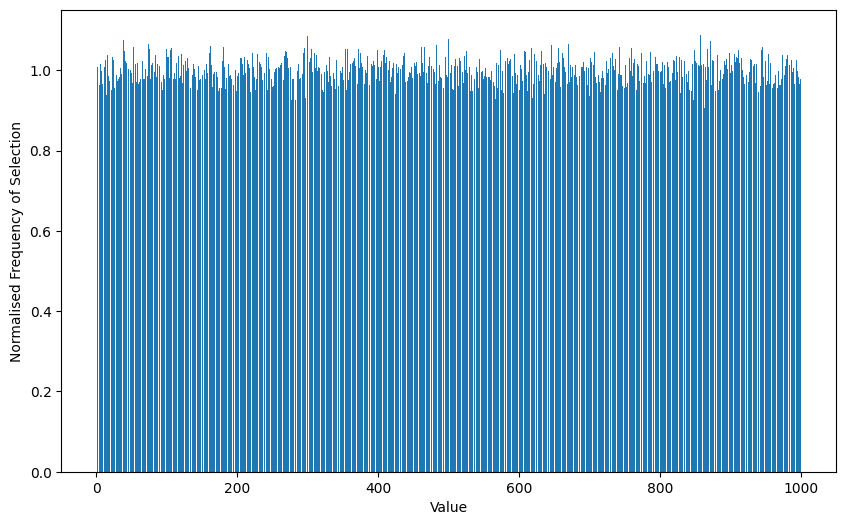

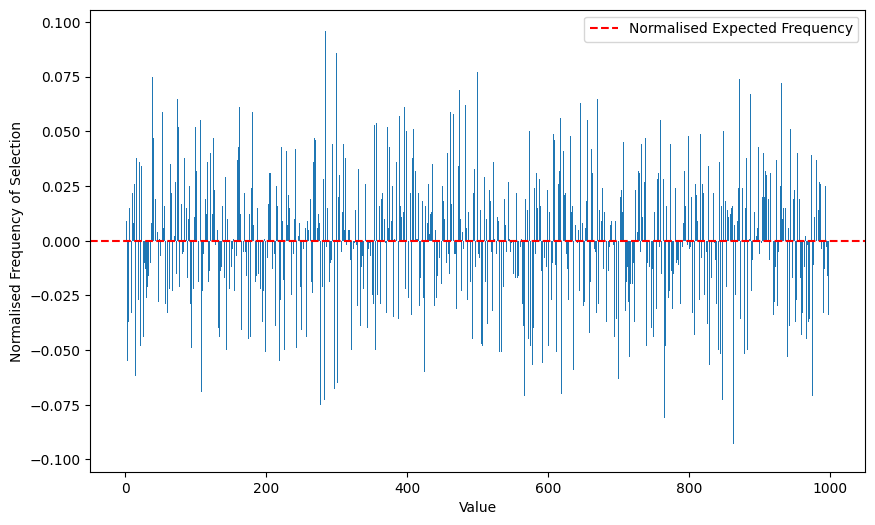

Top 10 values that deviate from the expected normalised value of 1.0:
283 1.096
132 0.904
862 0.907
826 1.088
857 1.088
299 1.086
843 0.917
477 1.082
764 0.919
623 1.081


In [123]:
""" Simple Reservoir Sampling

Routine is implemented to sample from [1, n_range], therefore we ignore the first element, 0, when processing
results in python (rather than doing a i - 1 mapping)
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    for j in result.args['selected']:
        occurrences[j] += 1

plot_frequency(m_samples, n_range, occurrences)
report_largest_deviations(m_samples, n_range, occurrences)


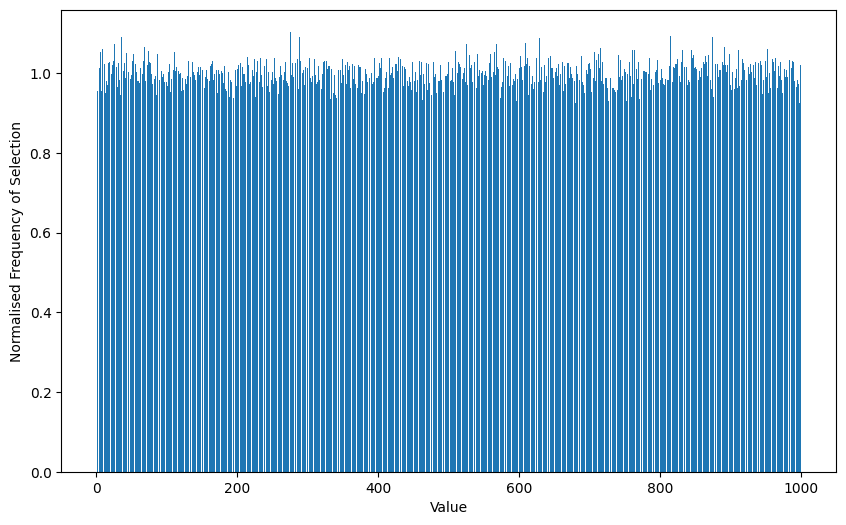

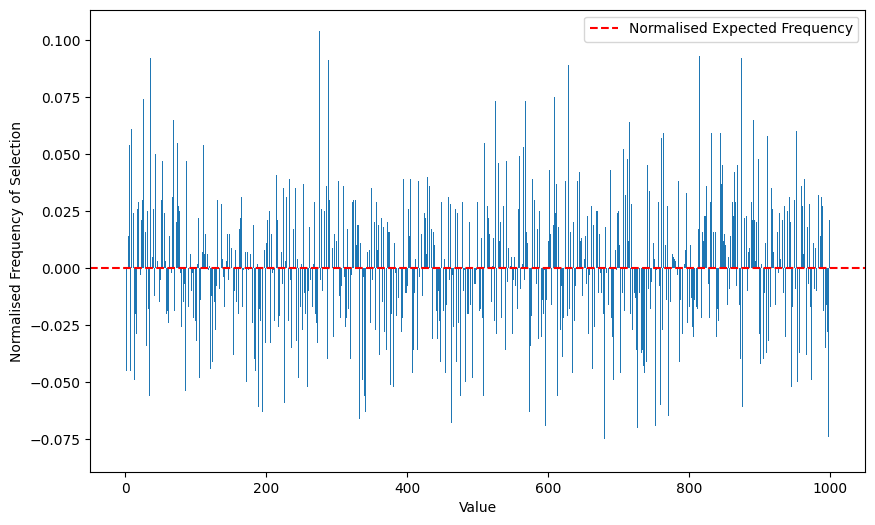

Top 10 values that deviate from the expected normalised value of 1.0:
275 1.104
814 1.093
874 1.092
35 1.092
551 1.091
288 1.091
628 1.089
236 1.087
944 1.086
700 1.084


In [124]:
""" Reservoir Sampling using Algorithm L.

Routine is implemented to sample from [1, n_range], therefore we ignore the first element, 0, when processing
results in python (rather than doing a i - 1 mapping)
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling_algorithml(m_samples, n_range, seeds, np.empty(shape=(m_samples)))
    # Fill counts
    for j in result.args['reservoir']:
        occurrences[j] += 1
        
plot_frequency(m_samples, n_range, occurrences)
report_largest_deviations(m_samples, n_range, occurrences)



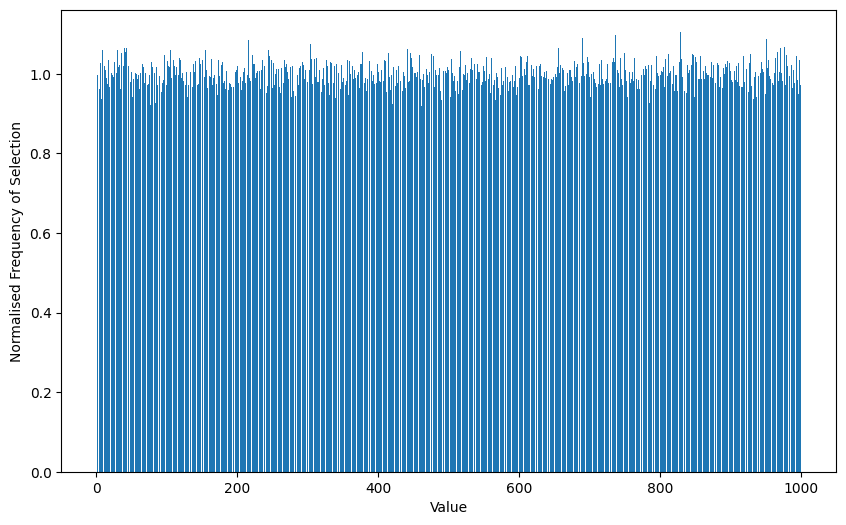

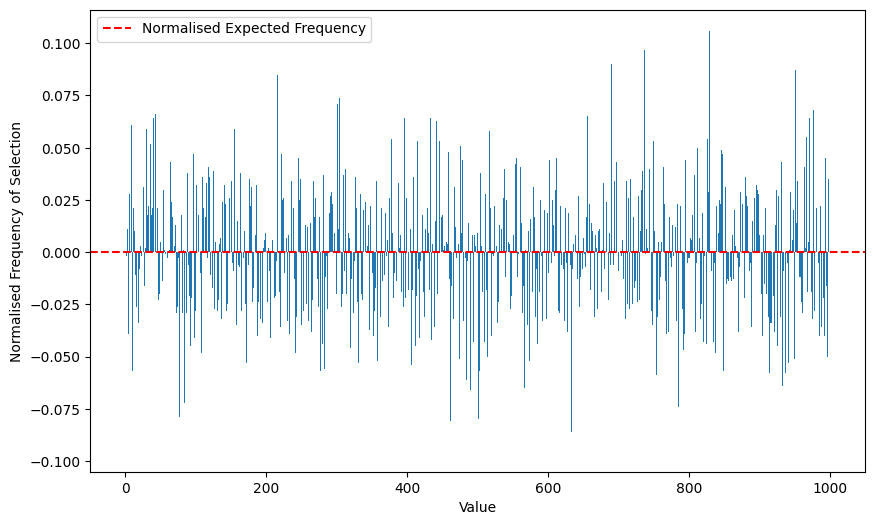

Top 10 values that deviate from the expected normalised value of 1.0:
828 1.106
667 1.1
736 1.097
338 0.905
689 1.09
165 0.913
950 1.087
30 1.086
632 0.914
215 1.085


In [125]:
""" Fisher-Yates Shuffle
"""
fy_shuffle_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/fisher_yates_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)
seed = int.from_bytes(os.urandom(16), 'big') 

for i in range(0, n_repeat):
    result = fy_shuffle_m.fisher_yates_shuffle(m_samples, n_range, seed, np.empty(shape=(m_samples)))
    seed = result.args['seed']
    for j in result.args['values']:
        occurrences[j] += 1
        
plot_frequency(m_samples, n_range, occurrences)
report_largest_deviations(m_samples, n_range, occurrences)


In [35]:
"""Hidden Shuffle

Appears to be an implementation error? Certainly returning the same erroneous number for the last element of some iterations

For a much large sample size  with larger range, it also throws up two erroneous iterations for the last 9 values
"""
hidden_shuffle_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/hidden_shuffle_m.mod')

m_samples = 10
n_range = 100
n_repeat = 100
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = hidden_shuffle_m. hidden_shuffle(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    try:
        for j in result.args['result']:
            occurrences[j] += 1
    except IndexError:
        print(f'Index error on iteration {i}')
        print(result.args['result'])


print('Asking for more samples, from a larger range')
m_samples = 1000
n_range = 100000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = hidden_shuffle_m. hidden_shuffle(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    try:
        for j in result.args['result']:
            occurrences[j] += 1
    except IndexError:
        print(f'Index error on iteration {i}')
        print(result.args['result'])


# Plotting takes 30-60 secs with this volume of data
plot_me = False

# Uniform probability of getting each value
if plot_me:
    plot_frequency(m_samples, n_range, occurrences)


Asking for more samples, from a larger range
Index error on iteration 523
[       130        315        382        451        497        623
        908       1016       1058       1166       1253       1255
       1268       1380       1600       1705       1762       2087
       2284       2288       2335       2359       2522       2728
       2818       2868       2919       3229       3238       3326
       3328       3345       3495       3667       3829       3916
       3928       4136       4174       4410       4432       4493
       4677       4683       4893       5076       5163       5286
       5490       5533       5696       5711       5986       6043
       6468       6541       6670       6848       6938       6975
       7063       7149       7306       7515       7531       7558
       7641       7726       7784       7869       7892       8025
       8038       8092       8279       8423       8454       8532
       8569       8712       8766       8857       8864

/Users/alexanderbuccheri/Codes/fortran_random/.venv/lib/python3.11/site-packages/gfort2py/fArrays.py:49: RuntimeWarning: invalid value encountered in cast
  value = value.astype(self.obj.dtype())


Index error on iteration 888
[        13        131        165        223        391        485
        501        785        981       1121       1200       1244
       1252       1270       1743       1789       1852       2029
       2063       2102       2212       2295       2463       2472
       2476       2529       2556       2562       2604       2672
       2676       2733       2838       2907       2929       2951
       3018       3501       3671       3776       4075       4101
       4183       4309       4443       4495       4514       4663
       4747       4785       4939       5082       5150       5169
       5352       5427       5725       5791       5883       5986
       6210       6254       6367       6425       6435       6760
       6850       6954       7059       7260       7365       7413
       7468       7558       7597       7602       7649       7799
       8065       8137       8291       8344       8418       8551
       8780       8839       8974

In [2]:
"""
Test Reservoir Sampling A-ExpJ Algorithm.

Weighted random sampling of m numbers from [1, n], without replacement.
"""
reservoir_sampling_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')
r_aexpj = reservoir_sampling_m.reservoir_sampling_aexpj

# Define weights 1 to 100, where values 30-49 are 1, and all others are epsilon
# As such, only expect to return numbers in the range 30-49, with no duplicates
m_samples = 20
n_range = 100
n_repeat = 10000

expected_values = np.arange(start=30, stop=30 + m_samples, step=1)

# Need to ensure minimum weight is quite large, perhaps as large as 1.
# and the meaningful weights are considerably larger (see below) to ensure out of 10,000 repeats,
# no instances of numbers with small weight get chosen.

print('This is a run where negligible weights are not small enough to ensure corresponding values are never chosen')

epsilon = 1.
weight = np.empty(shape=n_range)
weight.fill(epsilon)
weight[29:29+m_samples] = 1000000.

for i in range(0, n_repeat):
    seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
    result = r_aexpj(weight, np.empty(shape=(m_samples)), seed)
    reservoir = np.sort(result.args['reservoir'])
    if not np.array_equal(reservoir, expected_values):
        print(f'Iteration {i}:', reservoir)
    
print('Suitably large difference between small and large weights to ensure values with small weights are never chosen')

epsilon = 1.
weight = np.empty(shape=n_range)
weight.fill(epsilon)
weight[29:29+m_samples] = 10000000.

for i in range(0, n_repeat):
    seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
    result = r_aexpj(weight, np.empty(shape=(m_samples)), seed)
    reservoir = np.sort(result.args['reservoir'])
    if not np.array_equal(reservoir, expected_values):
        print(f'Iteration {i}:', reservoir)

print('Need 7 orders of magnitude difference')


This is a run where negligible weights are not small enough to ensure corresponding values are never chosen
Iteration 8712: [ 8. 30. 31. 32. 33. 34. 35. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49.]
Suitably large difference between small and large weights to ensure values with small weights are never chosen
Need 7 orders of magnitude difference


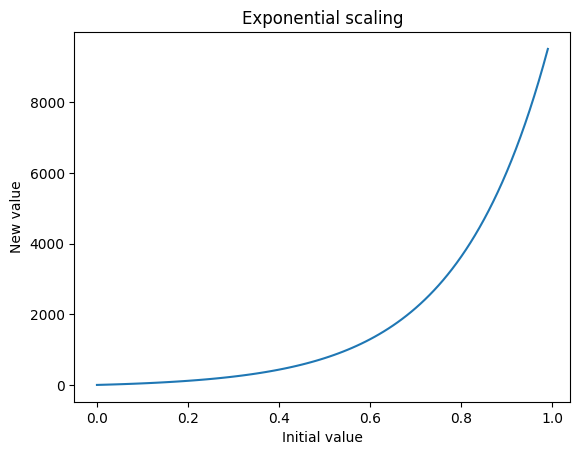

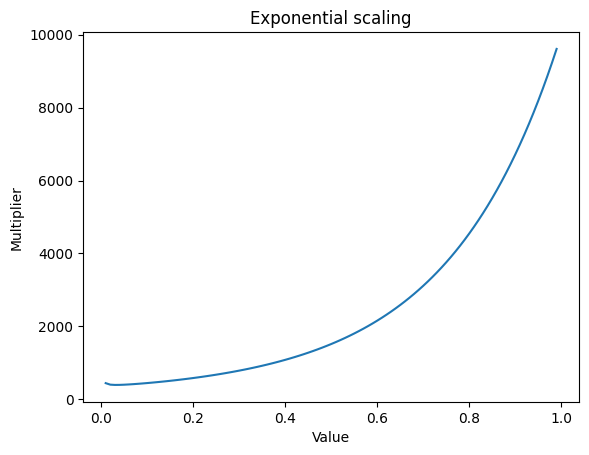

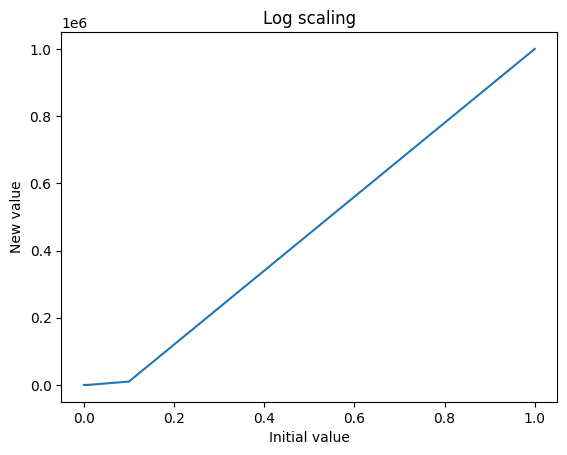

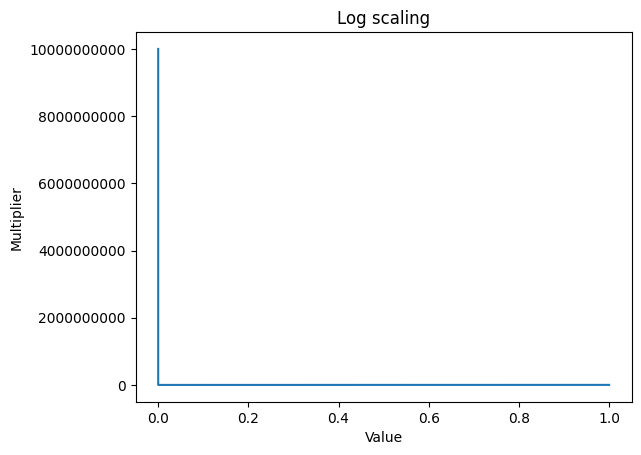

[0.e+00 1.e-10 1.e-08 1.e-06 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000100e+00
 1.00999999e+00 1.99999900e+00 1.00999900e+02 1.00009900e+04
 1.00000000e+06]
[1.00000000e+10 1.00000000e+08 1.00000100e+06 1.00999999e+04
 1.99999900e+03 1.00999900e+04 1.00009900e+05 1.00000000e+06]
[0.e+00 1.e-10 1.e-08 1.e-06 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
[1.00000000e+00 1.00050000e+00 1.04999995e+00 5.99998250e+00
 5.00874521e+02 4.98851582e+03 4.87715267e+04 3.93469947e+05
 9.93262060e+05]
[1.00050000e+10 1.04999995e+08 5.99998250e+06 5.00874521e+06
 4.98851582e+06 4.87715267e+06 3.93469947e+06 9.93262060e+05]


In [94]:
""" Test different scaling functions for [0, 1] to [1, c], where c is some arbitrarily large upper bound
"""

def linear_transformation(weights: np.ndarray, c: float) -> np.ndarray:
    return 1 + (c - 1) * weights
    

def exponential_rescale(arr, c, k=5):
    return 1 + (c - 1) * (np.exp(k * arr) - 1) / (np.exp(k) - 1)

# Not useful - will increase the relative size of small numbers
# Interesting to plot though, it's the reverse of the above
def log_rescale(arr, c, epsilon=1e-6):
    """Separation increases as values get smaller.
    Leaves probability of getting large values similar, but
    probability of getting small values much-reduced
    """
    scale = (np.log(arr + epsilon) - np.log(epsilon)) / (np.log(1 + epsilon) - np.log(epsilon))
    return 1 + (c - 1) * scale

# Compress smaller numbers
def power_law_rescale(arr, a, b, c, alpha=2):
    # Normalize the array from range [a, b] to [0, 1]
    normalise = (arr - a) / (b - a)
    # Apply the power-law transformation and rescale to [1, l]
    return 1 + (c - 1) * normalise**alpha

# Reverse exp scaling. Not appropriate as large values will become too similar.
def reverse_exponential_rescale(arr, a, b, c, k=5):
    normalise = (arr - a) / (b - a)
    return 1 + (c - 1) * (1 - np.exp(-k * normalise))


initial_weights = np.arange(0., 1., step=0.01)
weights_linear = linear_transformation(initial_weights, 10000)
weights_exp = exponential_rescale(initial_weights, 10000)

plt.plot(initial_weights, weights_exp)
plt.xlabel('Initial value')
plt.ylabel('New value')
plt.title("Exponential scaling")
plt.show()

# Plot how much each number has changed i.e. the magnifier
# Remove 0 from the plot, as 1 / 0 does not make sense
delta_weights = weights_exp[1:] / initial_weights[1:]
plt.plot(initial_weights[1:], delta_weights)
plt.xlabel('Value')
plt.ylabel('Multiplier')
plt.title("Exponential scaling")
plt.show()

# Log scaling
initial_weights = np.array([0., 1.e-10, 1.e-8, 1.e-6, 1.e-4, 1.e-3, 1.e-2, 0.1, 1])
weights_pl = power_law_rescale(initial_weights, 0., 1., 1e6, alpha=2)

plt.plot(initial_weights, weights_pl)
plt.xlabel('Initial value')
plt.ylabel('New value')
plt.title("Log scaling")
plt.show()

plt.gca().yaxis.get_major_formatter().set_scientific(False)
delta_weights = weights_pl[1:] / initial_weights[1:]
plt.plot(initial_weights[1:], delta_weights)
plt.xlabel('Value')
plt.ylabel('Multiplier')
plt.title("Log scaling")
plt.show()

print(initial_weights)
print(weights_pl)
print(delta_weights)

# Reverse exp scaling.
initial_weights = np.array([0., 1.e-10, 1.e-8, 1.e-6, 1.e-4, 1.e-3, 1.e-2, 0.1, 1])
weights_re = reverse_exponential_rescale(initial_weights, 0., 1., 1e6, k=5)
delta_weights = weights_re[1:] / initial_weights[1:]

print(initial_weights)
print(weights_re)
print(delta_weights)


msg = """Compression with the power law actually means that the multipliers are larger for the smallest values
because it is compressing them all close to 1. Then the largest 1-2 values blow up relative to the compressed 
values.

This approach should be fine is 
a) I tune this scaling for each domain, such that if it runs [1.e-10, 1.e-6], these aren't all compressed to 1.
b) I use a significantly large enough c such that my largest values are >> than those compressed to 1.


Best candidates look like this, or the initial exponential scaling.
"""

# 
# msg = """
# Exponential scaling  takes the function from ~ straight line and pushes the curvature from the centre to the bottom-right corner of the plot
# 
# Log scaling takes the function from ~ straight line and pushes the curvature from the centre to the top-left corner of the plot. 
# """
# print(msg)

In [43]:
"""Reservoir Sampling A-ExpJ Algorithm, but scaling of the weights with exponential
"""
reservoir_sampling_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')
r_aexpj = reservoir_sampling_m.reservoir_sampling_aexpj

m_samples = 20
n_range = 100
n_repeat = 10000

weight = np.zeros(shape=n_range)
weight[29:29+m_samples] = 1.

# c = 1.e3, k=2 returns values outside the large weighting range [29:49] of ~ 2500/10,000 times.
# c = 1.e4, k=5 returns values outside the large weighting range [29:49] of ~ 275/10,000 times.
# c = 1.e5, k=8 returns values outside the large weighting range [29:49] of ~ 40/10,000 times.
# c = 1.e6, k=10 returns values outside the large weighting range [29:49] of < 10/10,000 times
# c = 1.e7, k=12 returns values outside the large weighting range [29:49] of < 10/10,000 times

# Note, for the specific use case, occasionally returning low-probability values does not matter 
# as long as the least-probable never occur. In this test, anything that is not in the range [29:49]
# is least-possible, and see we want to entirely avoid these values.
# Note, in areas of low-density, this might actually be a bad approach

weight = exponential_rescale(weight, c=1e7, k=12)
expected_values = np.arange(start=30, stop=30 + m_samples, step=1)

n_outside = 0
for i in range(0, n_repeat):
    seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
    result = r_aexpj(weight, np.empty(shape=(m_samples)), seed)
    reservoir = np.sort(result.args['reservoir'])
    if not np.array_equal(reservoir, expected_values):
        n_outside += 1
        print(f'{n_outside}. Iteration {i}:', reservoir)


1. Iteration 3764: [30. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.
 49. 66.]


In [93]:
"""Reservoir Sampling A-ExpJ Algorithm, but scaling of the weights with power law
"""
reservoir_sampling_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')
r_aexpj = reservoir_sampling_m.reservoir_sampling_aexpj

m_samples = 20
n_range = 100
n_repeat = 10000

weight = np.zeros(shape=n_range)
weight[29:29+m_samples] = 1.

new_max = 1.e6
weight = power_law_rescale(weight, 0., 1., new_max, alpha=2)
# Confirm scaling
indices = np.concatenate((np.arange(0, 29, 1, dtype=int), 
                          np.arange(29+m_samples, n_range, 1, dtype=int))
                         )
assert np.allclose(weight[29:29+m_samples], new_max), 'Initially weights of one. Now c'
assert np.allclose(weight[indices], 1.0), 'Initially weights of zero. Now one'

# new_max = 1.e4, alpha=2 returns values outside the large weighting range [29:49] of ~ 250/10,000 times.
# new_max = 1.e4, alpha=4 returns values outside the large weighting range [29:49] of ~ 100/10,000 times.
# new_max = 1.e5, alpha=4 returns values outside the large weighting range [29:49] of ~ 38/10,000 times.
# new_max = 1.e6, alpha=6 returns values outside the large weighting range [29:49] of ~ 3/10,000 times.
# new_max = 1.e6, alpha=2 returns values outside the large weighting range [29:49] of ~ 2/10,000 times.

expected_values = np.arange(start=30, stop=30 + m_samples, step=1)
n_outside = 0
for i in range(0, n_repeat):
    seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
    result = r_aexpj(weight, np.empty(shape=(m_samples)), seed)
    reservoir = np.sort(result.args['reservoir'])
    if not np.array_equal(reservoir, expected_values):
        n_outside += 1
        print(f'{n_outside}. Iteration {i}:', reservoir)



1. Iteration 8182: [30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 44. 45. 46. 47. 48.
 49. 83.]


In [41]:
"""Reimplementation with the key function defined as -log(u_i) / weight(i) such that small weights < 1. are supported.

NOTE: The jump function, X_w has not been changed to be consistent with the key definition.
At best, the jumps are therefore suboptimal. At worst, the routine may give wrong results.
- I can't find a reference for what this algorithm should look like.

https://krlmlr.github.io/wrswoR/reference/sample_int.html

This is essentially the inverse of the prior weight:
 * Very low weights (1.e-6) give very large keys ~ 1e5 to 5.e6
 * Weights ~ 1000 give small keys ~1e-4
 * Weights ~ 10000 can crash this code
 
 suggesting that the weight should be normalised
"""

reservoir_sampling_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')
r_aexpj_w2 = reservoir_sampling_m.reservoir_sampling_aexpj_w2

# Define weights 1 to 100, where values 30-49 are 1, and all others are epsilon
# As such, only expect to return numbers in the range 30-49, with no duplicates
m_samples = 20
n_range = 100
n_repeat = 10000

expected_values = np.arange(start=30, stop=30 + m_samples, step=1)

# Using  as a weight does not work in this case (crashed python). Weights should probably be normalised.
print('This version is more stable with a normalised range of weights')
epsilon = 1.e-6
weight = np.empty(shape=n_range)
weight.fill(epsilon)
weight[29:29+m_samples] = 1.

for i in range(0, n_repeat):
    seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
    result = r_aexpj_w2(weight, np.empty(shape=(m_samples)), seed)
    reservoir = np.sort(result.args['reservoir'])
    if not np.array_equal(reservoir, expected_values):
        print(f'Iteration {i}:', reservoir)
        
        
epsilon = 1.e-8
weight = np.empty(shape=n_range)
weight.fill(epsilon)
weight[29:29+m_samples] = 1.

print(f'If negligible values are set to have weight {epsilon}, the probability of choosing one of these values'
      f'goes to zero in {n_repeat} runs')

for i in range(0, n_repeat):
    seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
    result = r_aexpj_w2(weight, np.empty(shape=(m_samples)), seed)
    reservoir = np.sort(result.args['reservoir'])
    if not np.array_equal(reservoir, expected_values):
        print(f'Iteration {i}:', reservoir)


This version is more stable with a normalised range of weights
Iteration 3925: [23. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48.]
Iteration 4463: [25. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48.]
Iteration 4880: [ 30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48. 100.]
If negligible values are set to have weight 1e-08, the probability of choosing one of these valuesgoes to zero in 10000 runs


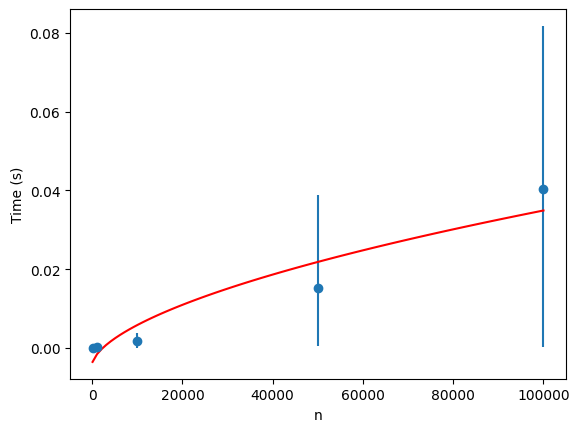

In [37]:
# Expect Reservoir Sampling L Algorithm to scale as O(n)
# Expect Reservoir Sampling A-ExpJ Algorithm to scale as O(m log(n/m))

import time
from scipy.optimize import curve_fit

reservoir_sampling_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')
r_aexpj_w2 = reservoir_sampling_m.reservoir_sampling_aexpj_w2

# m defined as sqrt(n)
n_range = np.array([100, 1000, 10000, 50000, 100000])
n_repeat = 100
epsilon = 1.e-8
m_samples = np.round(np.sqrt(n_range)).astype(int)
start_index = np.round(0.5 * (n_range - m_samples)).astype(int)

repeat_time = np.empty(shape=n_repeat)
timing = np.zeros(shape=len(n_range))
timing_min_max = np.zeros(shape=(len(n_range), 2))

# Loop over (n, m)
for i in range(0, len(n_range)):
    n = n_range[i]
    m = m_samples[i]
    istart = start_index[i]
    weight = np.empty(shape=n)
    weight.fill(epsilon)
    weight[istart:istart+m] = 1.

    # Compute several times and take the mean, for each sample size
    for it in range(0, n_repeat):
        seed = np.random.randint(-2**31, 2**31-1, dtype=np.int32)
        start = time.time()
        result = r_aexpj_w2(weight, np.empty(shape=m), seed)
        # Returned in result.args['reservoir']
        end = time.time()
        repeat_time[it] = end - start

    # Ignore first data point, just in case some caching of the code occurs after that
    timing[i] = np.mean(repeat_time[1:])
    timing_min_max[i, :] =  [np.amin(repeat_time[1:]), np.amax(repeat_time[1:])]

def scaling_func(x, a, b):
    # hard-code the relation between n and m
    m = np.sqrt(x)
    return a * (m * np.log(x / m)) + b

# Fit the scaling function
popt, pcov = curve_fit(scaling_func, n_range, timing)

plt.errorbar(n_range, timing, yerr=(timing_min_max[:, 0], timing_min_max[:, 1]) , marker='o', ls='None')
x_values = np.linspace(n_range[0], n_range[-1], 100, endpoint=True)
plt.plot(x_values, scaling_func(x_values, *popt), color='red', label='mlog(n/m)')
plt.xlabel('n')
plt.ylabel('Time (s)')
plt.show()
   

